<a href="https://colab.research.google.com/github/dkanh6/Machine_Learning_Examples/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First I am going to get the data into this python notebook

In [118]:
from google.colab import files
uploaded = files.upload()

import h5py
import numpy as np

# Initialize data structures for LFP recordings and segment counts
lfp = {'NREM': [], 'WAKE': []}
segment_counts = {'NREM': 0, 'WAKE': 0}

# Loop over each uploaded file
for filename in uploaded.keys():
    print(f'Processing file "{filename}" with length {len(uploaded[filename])} bytes')
    with h5py.File(filename, 'r') as f:  # Open the file
        # Assuming 'fs' is a global attribute for sampling frequency
        fs = f.attrs['fs'][0]
        print(f"Sampling rate: {fs:.1f} Hz")

        # Loop over states in each file
        for state in f.keys():
            group = f[state]  # Access the group corresponding to the state
            segment_ids = list(group.keys())  # List segment IDs within the state

            # Update the count of segments for the state
            segment_counts[state] += len(segment_ids)

            # Extract and store segment data from each file
            for segment_id in segment_ids:
                segment_data = np.array(group[segment_id]).astype(float)
                lfp[state].append(segment_data)

# Print the total number of segments for each state
for state, count in segment_counts.items():
    print(f"Total segments for state '{state}': {count}")


Saving Rat08-20130711_017.h5 to Rat08-20130711_017 (3).h5
Processing file "Rat08-20130711_017 (3).h5" with length 46559900 bytes
Sampling rate: 1250.0 Hz
Total segments for state 'NREM': 59
Total segments for state 'WAKE': 37


In [119]:
import h5py
import numpy as np

# Open the HDF5 file (which act as containers with folders inside that contain two separate objects that have datasets inside them)
filepath = next(iter(uploaded))  # Get the file path of the uploaded file
f = h5py.File(filepath, 'r')  # Open the file

# Initialize states based on the groups found in the HDF5 file
states = list(f.keys())  # This assumes all top-level groups represent different states

# Print basic file attributes and states found
fs = f.attrs['fs'][0]  # Assuming 'fs' is a global attribute for sampling frequency
print(f"Sampling rate: {fs:.1f} Hz")
print(f"States found: {states}")

# Initialize data structures for LFP recordings and segment counts
lfp = {state: [] for state in states}
segment_counts = {state: 0 for state in states}

for state in states:
    group = f[state]  # Access the group corresponding to the state
    segment_ids = list(group.keys())  # List segment IDs within the state
    segment_counts[state] = len(segment_ids)  # Count segments for the state

    for segment_id in segment_ids:
        # Extract and store segment data
        segment_data = np.array(group[segment_id]).astype(float)
        lfp[state].append(segment_data)

# Print the number of segments for each state
for state, count in segment_counts.items():
    print(f"State: {state}, Number of segments: {count}")


Sampling rate: 1250.0 Hz
States found: ['NREM', 'WAKE']
State: NREM, Number of segments: 59
State: WAKE, Number of segments: 37


Now I am going to quickly extract and visualize the data
I am going to extract segments within each state and visualize some of the segments so I can use them as training data.

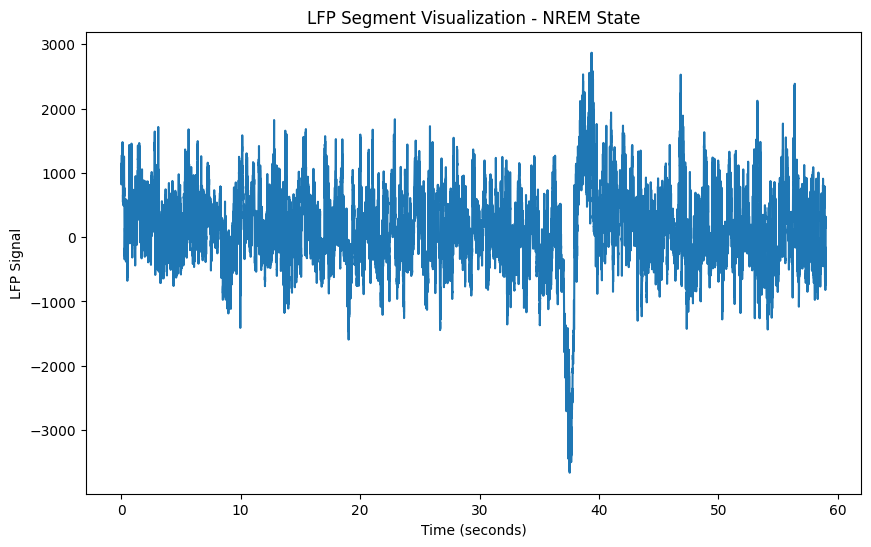

In [120]:
import matplotlib.pyplot as plt

state = 'NREM'  # The state you're interested in
segment_index = 2  # The segment index you want to visualize

# Check if the state and segment index are valid
if state in lfp and segment_index < segment_counts[state]:
    x = lfp[state][segment_index]
    t = np.arange(len(x)) / fs  # Time axis

    plt.figure(figsize=(10, 6))
    plt.plot(t, x)
    plt.xlabel('Time (seconds)')
    plt.ylabel('LFP Signal')
    plt.title(f'LFP Segment Visualization - {state} State')
    plt.show()
else:
    print(f"Data for state '{state}' with index {segment_index} is not available.")

In [121]:
# Ensure sampling_rate and clip_duration are defined correctly
sampling_rate = int(fs)  # Convert to integer if not already
clip_duration = 5  # Duration in seconds

# Calculate samples per clip and explicitly convert to integer
samples_per_clip = int(clip_duration * sampling_rate)

# Now, use this corrected `samples_per_clip` in your loop
clips = {state: [] for state in states}

for state in states:
    for segment in lfp[state]:
        num_clips = len(segment) // samples_per_clip

        for i in range(num_clips):
            start_sample = i * samples_per_clip
            end_sample = start_sample + samples_per_clip
            clip = segment[start_sample:end_sample]
            clips[state].append(clip)
        # ignoring partial clips that are not 5 seconds. opting to not pad them with zeros and use them for training
for state in clips:
    num_clips = len(clips[state])
    print(f"State: {state}, Number of 5-second clips: {num_clips}")


State: NREM, Number of 5-second clips: 1239
State: WAKE, Number of 5-second clips: 2443


Next I need to extract some various features that I can feed into the network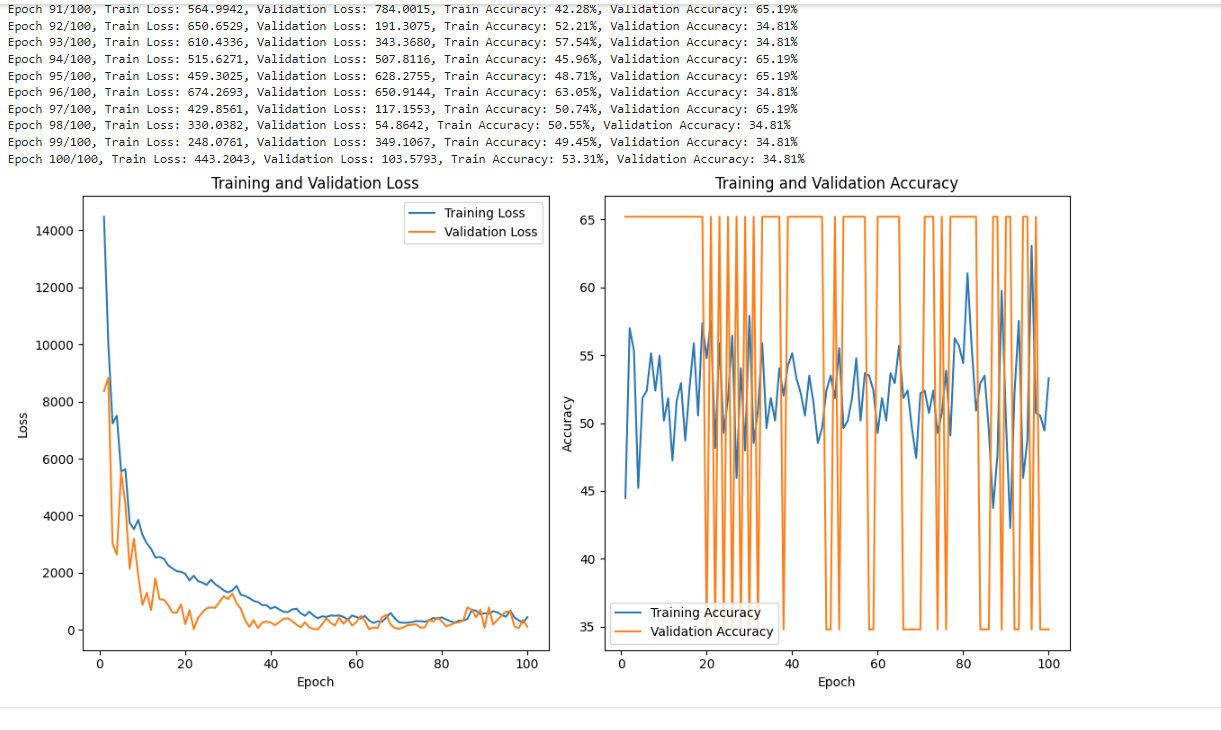

In [122]:
from scipy.stats import skew, kurtosis

# Initialize a dictionary to hold the clip data along with their computed features for each state
clip_features = {'NREM': [], 'WAKE': []}

for state in clips:
    for clip in clips[state]:
        # Calculate various statistics for the current clip
        clip_mean = np.mean(clip)
        clip_std = np.std(clip)
        clip_skewness = skew(clip)
        clip_kurtosis = kurtosis(clip)
        #clip_entropy = entropy(np.histogram(clip, bins=10)[0])

        # Append the clip and its computed features as a dictionary to the state's list
        clip_features[state].append({
            'clip': clip,
            'mean': clip_mean,
            'std': clip_std,
            'skewness': clip_skewness,
            'kurtosis': clip_kurtosis,
            #'entropy': clip_entropy
        })

# Accessing and displaying the features of the first clip for 'NREM' state
first_nrem_clip_features = clip_features['NREM'][0]
print("Features of the first 'NREM' clip:")
print(f"Mean: {first_nrem_clip_features['mean']}")
print(f"STD: {first_nrem_clip_features['std']}")
print(f"Skewness: {first_nrem_clip_features['skewness']}")
print(f"Kurtosis: {first_nrem_clip_features['kurtosis']}")

# If original signa still needed:
example_clip = first_nrem_clip_features['clip']


Features of the first 'NREM' clip:
Mean: 34.792
STD: 698.1702320322745
Skewness: 0.21606066352768008
Kurtosis: -0.48215938742358544


Now, I am going to do some PSD calculations using a small portion of the clip (maybe 1/5th of the total clip length)


In [123]:
from scipy.signal import welch

# Initialize a new key in the dictionary for PSD
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip = clip_feature['clip']

        # Choose nperseg as a fraction of the clip length for lower frequency resolution
        # Example: Using 1/4th of the clip length
        nperseg = len(clip) // 4

        # Calculate the PSD using Welch's method
        frequencies, psd = welch(clip, fs=sampling_rate, nperseg=nperseg)

        # Store the PSD data in the clip's feature dictionary
        clip_feature['psd'] = psd
        clip_feature['frequencies'] = frequencies

# Example: Accessing the PSD of the first clip for 'NREM' state
first_nrem_clip_features = clip_features['NREM'][0]
print("PSD of the first 'NREM' clip (first 10 values):")
print(first_nrem_clip_features['psd'][:10])
print("Frequencies of the first 'NREM' clip (first 10 values):")
print(first_nrem_clip_features['frequencies'][:10])

PSD of the first 'NREM' clip (first 10 values):
[18944.92492392 62178.9975459  26733.93324896 13842.76485718
  6711.64877445  3410.03794675  5303.35886803  6408.1468584
  8138.92701462  4932.13993321]
Frequencies of the first 'NREM' clip (first 10 values):
[0.         0.80025608 1.60051216 2.40076825 3.20102433 4.00128041
 4.80153649 5.60179257 6.40204866 7.20230474]


Now to find oscillation frequency bands in the PSD of each state to identify where the largest frequency band and use it as a feature

In [124]:
from scipy.signal import butter, sosfilt, sosfreqz

# Function to create a bandpass filter and apply it
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    filtered = sosfilt(sos, data)
    return filtered

# Identify your bands here based on the overall PSD analysis
# Example: Assuming you found a significant band from 5 to 12 Hz
bands = {
    'theta': (5, 12),
}

# Apply bandpass filtering and calculate statistics for each clip in each state
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip = clip_feature['clip']
        for band_name, (lowcut, highcut) in bands.items():
            # Filter the clip for the current band
            filtered_clip = bandpass_filter(clip, lowcut, highcut, fs=sampling_rate)

            # Calculate statistics on the filtered signal
            mean_power = np.mean(filtered_clip ** 2)
            std_power = np.std(filtered_clip ** 2)

            # Store the statistics in the clip's feature dictionary
            if 'band_stats' not in clip_feature:
                clip_feature['band_stats'] = {}
            clip_feature['band_stats'][band_name] = {'mean_power': mean_power, 'std_power': std_power}

# Example: Display the band-specific stats for the first NREM clip
first_nrem_clip_features = clip_features['NREM'][0]
print("Band-specific stats for the first 'NREM' clip:")
print(first_nrem_clip_features['band_stats'])


Band-specific stats for the first 'NREM' clip:
{'theta': {'mean_power': 40079.14433176896, 'std_power': 56804.77614687043}}


Now to normalize the features

In [125]:
from scipy.stats import zscore

# First, flatten features values to apply normalization
mean_powers = [clip_feature['band_stats']['theta']['mean_power'] for state in clip_features for clip_feature in clip_features[state]]

# Apply Z-score normalization
mean_powers_normalized = zscore(mean_powers)

# Update original data structure with normalized values
i = 0  # Initialize a counter to track the current index in normalized values
for state in clip_features:
    for clip_feature in clip_features[state]:
        clip_feature['band_stats']['theta']['mean_power_normalized'] = mean_powers_normalized[i]
        i += 1


Now separate into training, testing, and cross validation

In [126]:
from sklearn.model_selection import train_test_split

# Example ratios
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

# Prepare features and labels
features = []
labels = []  # Assuming 0 for NREM and 1 for WAKE

for state in clip_features:
    for clip_feature in clip_features[state]:
        # Assuming mean_power_normalized and std_power as the features for simplicity
        mean_power_normalized = clip_feature['band_stats']['theta']['mean_power_normalized']
        std_power = clip_feature['band_stats']['theta']['std_power']

        # Create a feature vector for each clip
        feature_vector = [mean_power_normalized, std_power]
        features.append(feature_vector)

        # Append the label
        label = 0 if state == 'NREM' else 1
        labels.append(label)

# Convert to NumPy arrays for easier manipulation
features = np.array(features)
labels = np.array(labels)

# Splitting the dataset into training, validation, and testing sets
# First, split into training and temporary sets (temp will be further split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, train_size=train_ratio, random_state=42)

# Calculate the split ratio for validation
validation_size = validation_ratio / (validation_ratio + test_ratio)

# Now split the temporary set into validation and test sets
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=validation_size, random_state=42)



Now that i have my data processed into features and separated into test, train, and cross validation the actual traning needs to be done using pytorch.

Epoch 1/50, Train Loss: 338.9535, Validation Loss: 32.3671, Train Accuracy: 53.42%, Validation Accuracy: 66.71%
Epoch 2/50, Train Loss: 134.4059, Validation Loss: 28.2717, Train Accuracy: 56.00%, Validation Accuracy: 66.71%
Epoch 3/50, Train Loss: 49.6439, Validation Loss: 5.5636, Train Accuracy: 52.56%, Validation Accuracy: 66.71%
Epoch 4/50, Train Loss: 16.0009, Validation Loss: 5.4964, Train Accuracy: 57.18%, Validation Accuracy: 66.71%
Epoch 5/50, Train Loss: 5.2358, Validation Loss: 0.7729, Train Accuracy: 52.42%, Validation Accuracy: 66.71%
Epoch 6/50, Train Loss: 1.1274, Validation Loss: 0.6751, Train Accuracy: 53.73%, Validation Accuracy: 66.71%
Epoch 7/50, Train Loss: 0.8604, Validation Loss: 0.7198, Train Accuracy: 55.50%, Validation Accuracy: 66.71%
Epoch 8/50, Train Loss: 0.8252, Validation Loss: 1.5555, Train Accuracy: 57.04%, Validation Accuracy: 66.71%
Epoch 9/50, Train Loss: 1.0419, Validation Loss: 0.7499, Train Accuracy: 57.22%, Validation Accuracy: 66.71%
Epoch 10/50

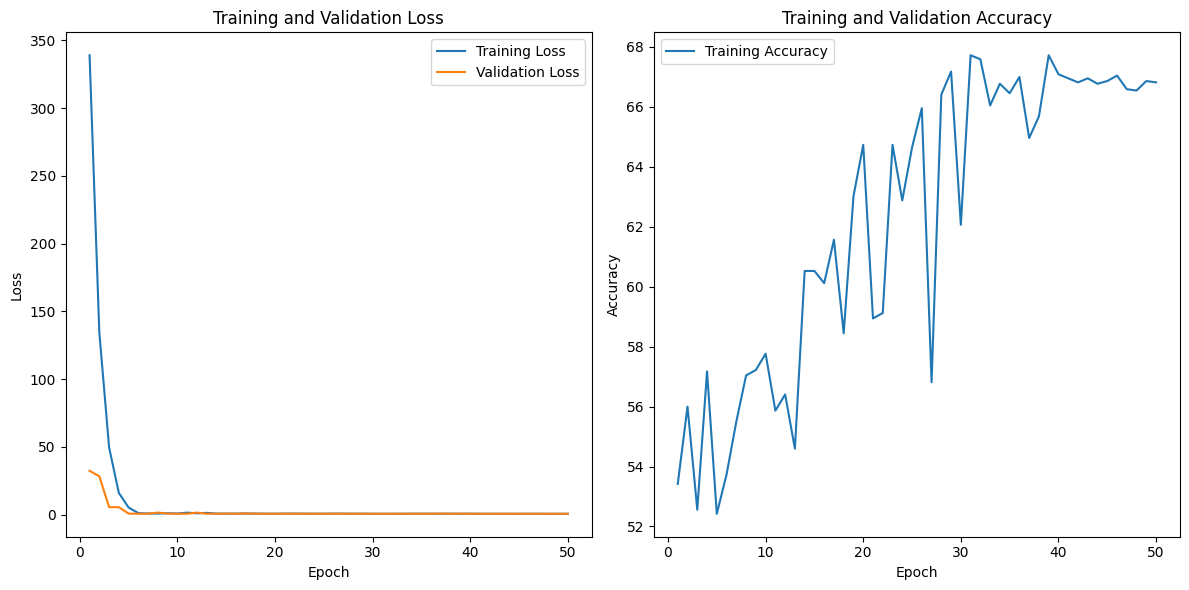

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#class SimplifiedNN(nn.Module):
#   def __init__(self, input_size, output_size):
#        super(SimplifiedNN, self).__init__()
#        self.network = nn.Sequential(
#            nn.Linear(input_size, 64),   # First hidden layer
#            nn.ReLU(),                   # Activation function
#            nn.Dropout(0.3),             # Dropout for regularization
#            nn.Linear(64, 32),           # Second hidden layer
#            nn.ReLU(),                   # Activation function
#            nn.Linear(32, output_size)   # Output layer
#        )

#    def forward(self, x):
#        return self.network(x)


class CNNSignalNet(nn.Module):
    def __init__(self, sequence_length, output_size):
        super(CNNSignalNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)

        # Calculate the size after convolutional layers (without pooling)
        # The size remains the same if stride is 1 and padding matches the kernel size divided by 2
        convoluted_length = sequence_length  # No pooling layers to modify the length

        # Ensure the resulting convoluted_length is valid
        if convoluted_length <= 0:
            raise ValueError(f"The resulting length after convolutions is non-positive: {convoluted_length}")

        self.fc1 = nn.Linear(32 * convoluted_length, 64)  # Adjusted for the output of conv2
        self.fc2 = nn.Linear(64, output_size)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Ensure input tensor is of the form [batch_size, channels, sequence_length]
        x = x.unsqueeze(1) if x.ndim == 2 else x

        # Convolutional layers with ReLU
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Convert split data into PyTorch datasets, then into DataLoader for batching
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
validation_data = TensorDataset(torch.FloatTensor(X_validation), torch.LongTensor(y_validation))

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=False)

input_size = features.shape[1]  # Number of features
output_size = 2  # binary classification (e.g., NREM and WAKE)

#model = SimplifiedNN(input_size, output_size)
#model = ComplexNN(input_size, output_size)
model = CNNSignalNet(input_size, output_size)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Learning rate

epochs = 50
train_losses, validation_losses, train_accuracies, validation_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / total_predictions * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    validation_loss = validation_loss / len(validation_loader.dataset)
    validation_accuracy = correct / len(validation_loader.dataset) * 100
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {validation_accuracy:.2f}%')


def plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    #plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, validation_losses, train_accuracies, validation_accuracies)

**Signal processing and Feature Engineering**
first I did some signal processing and found some relevant fetures to extract such as mean, standard deviation, skewness, power spectral density, and kurtosis. One large problem I faced when I was first starting to work with these is figuring out how to use the library functions properly and then store said information with each associated clip. Another problem I ran into is that at first I was only able to load one fil at a time and if i tried to load multiple files to increase the dataset size than it would only take the clips from the first uploaded file. Finally, the other most notable issue I enocuntered in this phase was simply understanding how this file format worked and then discovering there was a pretty powerful python library already made for it.

**Network architectures**
It is likely just how new I am to working with NN and this library in general, but I ran into constant problems getting the NN to function properly and I think a lorge component was not being able to see the NN myself such that when I would accidentally maxpool too mcuh I was reducing the feature space too drastically to the point that it was deterimental, but I coudnlt' intuit that i was making such a mitake since it was hard to visualize teh changes I was making. I started with basic feedborward networks, and then started to experimntl with differen strucuers including CNN,s and trying to adjust the complexity to avoid overfitting while retaining its capabilities, but this is the section that I ran into the most problem figuring out. I constantly experiencies accuracy plateauing and issues caed by pooling layers that excessively reduced tensor dimensions. I addresed most of these issue by fine tunnig some paramter architecutres, complexity, and various hyper paramters like learning rate or just simply removing the problem layers.

Additional problems encountered: I have tried countless things to try and fix it, but I need to move on from this project and start dedicating the restof my time to work and research so I am unable to figure out everyproblem, but pretty much no matter what size I made my learning rate my cross validation data would jump (almost oscillate) from high to low and I was never able to get that under control. I wonder if there was some accidental overlap in the datasets even after I split them up and that is maybe cuasing some of the weird behavior?

**Submission and Documentation**
The final notebook methodically outlines the entire process from data preprocessing to model evaluation. It includes concise explanations for each methodological choice and presents results through clear, interpretable plots. The concluding section summarizes key findings and suggests directions for further research.

This project underscored the importance of iterative exploration in signal processing and machine learning, demonstrating how tailored approaches to feature engineering and model architecture can significantly enhance performance in complex classification tasks, but man oh man did it teach me how fickle these networks are. Though they appear powerful if you are not careful you can really end up with some delicate networks (at least with my piepline, which likely has a leak or two in it somewhere). Ultiamtely I would like to try again but with an easier and smaller dataset before moving up to something as complicated as this. Below you will see the accuracy plots between all 3 files

subject 1 part 1 https://drive.google.com/file/d/1QY0DmxszXrD73H66V8OKNgIm6Lu5FAWu/view?usp=drive_link

subject part 2 https://drive.google.com/file/d/1F3T_uUlY9wyPOJrqY7TFuR32DWqGkfds/view?usp=drive_link

rat https://drive.google.com/file/d/1m92TmzAPp_8yc4ooCuhMw-RGCxAc3zlN/view?usp=drive_link
